<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Project_Solution/StandaloneDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Systems Lab Project

#### Standalone demo

The purpose of this notebook is to provide a standalone demo which fullfills the minimum passing requirements of the project. The only inevitable prerequisite is to obtain the *data_scene_flow* zip archive of the KITTI dataset and place it into a Google Drive which can be made available to this notebook session.

In [1]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
from PIL import Image
import os
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler
import torch.jit as jit

### Mounting the Dataset



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
if not os.path.exists('data'):
    os.makedirs('data')
try:
  shutil.rmtree('data')
except:
  pass

if not os.path.exists('models'):
    os.makedirs('models')
try:
  shutil.rmtree('models')
except:
  pass

if not os.path.exists('trainer_logs'):
    os.makedirs('trainer_logs')
try:
  shutil.rmtree('trainer_logs')
except:
  pass

In [4]:
print('Extracting files...')
!unzip /content/gdrive/MyDrive/data_scene_flow.zip -d data &> /dev/null
!unzip /content/gdrive/MyDrive/models.zip &> /dev/null
!unzip /content/gdrive/MyDrive/trainer_logs.zip &> /dev/null
print('Done')

Extracting files...
Done


### Helper Functions

In [5]:
## Filepath helper functions
### KITTI
def get_left_frames_kitti(kitti_root = '/content/data'):
    """Return the paths of all left camera images in the KITTI dataset."""
    
    image_2_path = os.path.join(kitti_root, 'training/image_2')
    left_imgs_paths = []
    for img in os.listdir(image_2_path):
        if '10.png' in img:
            left_imgs_paths.append(os.path.join(image_2_path, img))
    return left_imgs_paths
        
def left_to_right_kitti(left_img_path):
    """Convert the path to a left image in the KITTI dataset to the path of the corresponding right image."""
    
    split_path = left_img_path.split('/')
    root, _, img = split_path[:-2], split_path[-2], split_path[-1]
    return os.path.join('/', *root, 'image_3', img)

def left_to_disparity_kitti(left_img_path, mode='disp_occ_0'):
    """Convert the path to a left image in the KITTI dataset to the path of the corresponding disparity map.
    
    There are different types of disparity maps in KITTI, selectable via the mode argument. They are:
    'disp_noc_0', 'disp_occ_0', 'disp_noc_1' and 'disp_occ_1', where
    
    'noc' refers to non-occluded regions, ie, regions for which the matching correspondence is inside the image domain. 
    'occ'refers to all image regions for which ground truth could be measured
    
    '0' refers to disparity maps of first image pairs in reference frame
    '1' refers to disparity information of second image pair mapped into the reference frame via true optical flow

    This functions differs from left_to_right_disparity_kitty() only in the standard selected mode.
    """
    
    split_path = left_img_path.split('/')
    root, img = split_path[:-1], split_path[-1]
    root[-1] = mode
    return os.path.join('/', *root, img)

def left_to_right_disparity_kitti(left_img_path, mode='disp_occ_1'):
    """Convert the path to a left image in the KITTI dataset to the path of the corresponding right disparity map.
    
    There are different types of disparity maps in KITTI, selectable via the mode argument. They are:
    'disp_noc_0', 'disp_occ_0', 'disp_noc_1' and 'disp_occ_1', where
    
    'noc' refers to non-occluded regions, ie, regions for which the matching correspondence is inside the image domain. 
    'occ'refers to all image regions for which ground truth could be measured
    
    '0' refers to disparity maps of first image pairs in reference frame
    '1' refers to disparity information of second image pair mapped into the reference frame via true optical flow

    This functions differs from left_to_disparity_kitty() only in the standard selected mode.
    """
    
    split_path = left_img_path.split('/')
    root, img = split_path[:-1], split_path[-1]
    root[-1] = mode
    return os.path.join('/', *root, img)
  
## Image and disparity map loading functions
### KITTI
def load_image_kitti(img_path):
    """Load the torch tensor containing an image from the KITTI dataset.
    
    The shape of the tensor is [3, 375, 1242].
    """
    
    return torch.tensor(np.asarray(Image.open(img_path))).float().permute(2,0,1)/255.

def load_disparity_kitti(disparity_path):
    """Load the torch tensor containing a disparity map from the KITTI dataset.
    
    The shape of the tensor is [1, 375, 1242].
    """
    
    return torch.tensor(np.asarray(Image.open(disparity_path))).float().unsqueeze(0)/256.

### Dataset

In [6]:
class DisparityDataset(Dataset):
    """
    Dataset class which provides items of the form (left image, right image), disparity map.
    
    It is based on cacheing the list of paths to left images in a list, and on the assumption that there is a systematic way to       convert the path to a left image into the paths to a right image and a corresponding disparity map. This conversion is assumed 
    to be described by a function left2right and left2disparity, respectively. 
    Since the images are often saved in different forms, and so are the disparity maps, a function which loads such an image or 
    disparity given the file path is required for the images and disparities. Transforms can also be applied, it should be of a 
    joint form:  
    (img_left_transformed, img_right_transformed), disparity_transformed <- transform((img_left, img_right), disparity)
    """ 
    
    def __init__(self, left_paths, left2right, left2disparity, load_image, load_disparity, transform=None):
        self.left_paths = left_paths
        self.right_paths = [left2right(path) for path in left_paths]
        self.disp_paths = [left2disparity(path) for path in left_paths]
        
        self.load_image = load_image
        self.load_disparity = load_disparity
        self.transform = transform
        return
    
    def __len__(self):
        """Return the number of file paths."""
        
        return len(self.left_paths)

    def __getitem__(self, i):
        """ 
        Loads left image, right image and disparity by corresponding file path at index i, finally apply transform.
        """
        
        left_img_path, right_img_path = self.left_paths[i], self.right_paths[i]
        disparity_path = self.disp_paths[i]
        
        left_img, right_img = self.load_image(left_img_path), self.load_image(right_img_path)
        disparity_map = self.load_disparity(disparity_path)

        if self.transform:
            (left_img, right_img), disparity_map = self.transform((left_img, right_img), disparity_map)

        return (left_img, right_img), disparity_map

### Transforms

In [7]:
class RandomCrop(object):
    """Randomly crop an image pair and the corresponding disparity map.
    
    This is very close to the transform example from:
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    The output size can be specified either as an int (square crop) or as a tuple (y, x)
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, imgs, disparity):
        img_left, img_right = imgs

        h, w = img_left.shape[-2:]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img_left = img_left[:, top: top + new_h, left: left + new_w]
        img_right = img_right[:, top: top + new_h, left: left + new_w]
        disparity = disparity[:, top: top + new_h, left: left + new_w]

        return (img_left, img_right), disparity
    
class DisparityTransform(object):
    """Apply a given image transform to the left and right image pair and optionally to the disparity map.
    
    Note that this class is not suited for handling nondeterministic transformations.
    The apply_to_disparity flag toggles whether the transform should be applied to the disparity map as well.
    """

    def __init__(self, transform, apply_to_disparity=True):
        self.transform = transform
        self.apply_to_disparity = apply_to_disparity

    def __call__(self, imgs, disparity):
        img_left, img_right = imgs

        img_left, img_right = self.transform(img_left), self.transform(img_right)
        if self.apply_to_disparity:
            disparity = self.transform(disparity)
            
        return (img_left, img_right), disparity

class DisparityTransformCompose(object):
    """Apply a list of disparity transforms to the left and right image pair and the disparity map."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, imgs, disparity):
        for transform in self.transforms:
            imgs, disparity = transform(imgs, disparity)
        img_left, img_right = imgs
        
        return (img_left, img_right), disparity

### More Transforms

In [8]:
class MixUp(object):
    """Randomly blend the input image pair and the corresponding disparity map with another image pair and disparity map, respectively.
    
    The other image pair must be drawn from a Dataset class which is expected to provide compatible images and maps in terms of ranges and shapes.
    Slightly adjusted from https://arxiv.org/pdf/1710.09412.pdf
    """

    def __init__(self, dataset: Dataset):
        self.dataset = dataset
        self.len = len(self.dataset)
        self.eps = 1e-12

    def __call__(self, imgs, disparity):
        img_left, img_right = imgs

        rd_index = np.random.randint(self.len)
        (img_left_rd, img_right_rd), disparity_rd = self.dataset.__getitem__(rd_index)
        
        disparity_mask = disparity < self.eps
        disparity_mask_rd = disparity_rd < self.eps

        alpha = np.random.uniform()
        img_left_interpolate = alpha * img_left + (1 - alpha) * img_left_rd
        img_right_interpolate = alpha * img_right + (1 - alpha) * img_right_rd
        disparity_interpolate = alpha * disparity + (1 - alpha) * disparity_rd
        
        disparity_interpolate[disparity_mask] = 0.
        disparity_interpolate[disparity_mask_rd] = 0.

        return (img_left_interpolate, img_right_interpolate), disparity_interpolate

class CutMix(object):
    """Randomly blend the input image pair and the corresponding disparity map with another image pair and disparity map, respectively.
    
    The other image pair must be drawn from a Dataset class which is expected to provide compatible images and maps in terms of ranges and shapes.
    Implemented according to pseudocode from https://arxiv.org/pdf/1905.04899.pdf
    """

    def __init__(self, dataset: Dataset):
        self.dataset = dataset
        self.len = len(self.dataset)
        _, test_image = dataset.__getitem__(0)
        self.W, self.H = test_image.shape[-2:]

    def __call__(self, imgs, disparity):
        img_left, img_right = imgs
        lam = np.random.uniform()
        r_x = np.random.uniform()*self.W
        r_y = np.random.uniform()*self.H
        # the following two lines correct a typo in the paper pseudocode
        r_w = np.sqrt(1-lam)*self.W
        r_h = np.sqrt(1-lam)*self.H

        x_1 = int(np.round(np.max([r_x-r_w/2,0])))
        x_2 = int(np.round(np.min([r_x+r_w/2,self.W])))
        y_1 = int(np.round(np.max([r_y-r_h/2,0])))
        y_2 = int(np.round(np.min([r_y+r_h/2,self.H])))
        # since we apply CutMix element-wise, replace batch shuffle by this
        mix_ind = np.random.randint(self.len)
        (img_left_mix, img_right_mix), disparity_mix = self.dataset.__getitem__(mix_ind)

        # what to do when the sample is an image
        img_l_out, img_r_out, disparity_out = img_left.clone(), img_right.clone(), disparity.clone()
        img_l_out[:, y_1:y_2, x_1:x_2] = img_left_mix[:, y_1:y_2, x_1:x_2]
        img_r_out[:, y_1:y_2, x_1:x_2] = img_right_mix[:, y_1:y_2, x_1:x_2]
        disparity_out[:, y_1:y_2, x_1:x_2] = disparity_mix[:, y_1:y_2, x_1:x_2]

        return (img_l_out, img_r_out), disparity_out

## Create Dataset and Dataloader

In [9]:
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
                                       RandomCrop(output_size=(256,512))])


transform_large = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
                                       RandomCrop(output_size=(368,1220))])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)


kitti_dataset = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform)
kitti_dataset_large = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform_large)
print('Number of samples in the KITTI dataset:', len(kitti_dataset))

BATCHSIZE = 20
BATCHSIZE_VALID = 10 # Relevant because the images are larger
train_share = 0.75
N_samples = len(kitti_dataset)
indices = list(range(N_samples))
split = int(np.ceil(train_share * N_samples))
#np.random.shuffle(indices)

train_idx, valid_idx = indices[:split], indices[split:]
print(len(train_idx), len(valid_idx))
trainset = torch.utils.data.Subset(kitti_dataset, train_idx)
validset = torch.utils.data.Subset(kitti_dataset_large, valid_idx)

transform = DisparityTransformCompose([transform,
                                       MixUp(trainset)])

kitti_dataset = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform)
trainset = torch.utils.data.Subset(kitti_dataset, train_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCHSIZE_VALID, shuffle=False, num_workers=2)

Number of samples in the KITTI dataset: 200
150 50


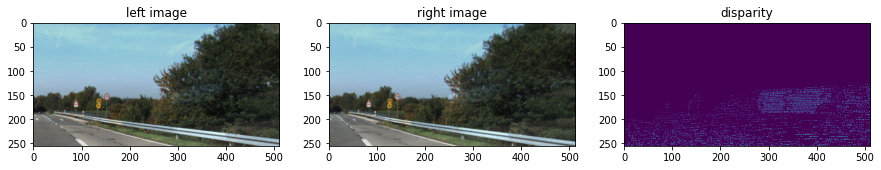

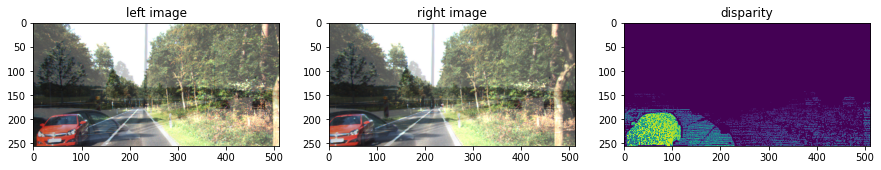

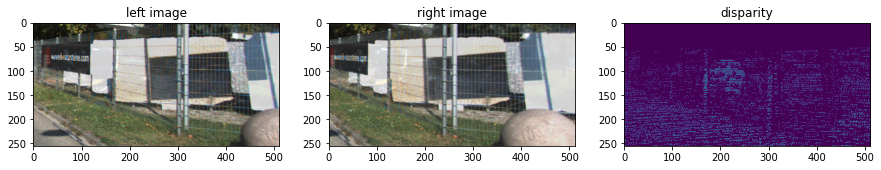

In [10]:
for i in np.random.choice(np.arange(len(trainset)), size=3, replace=False):
    (img_left, img_right), img_disparity = trainset[i]
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze())
    axes[2].set_title('disparity')
    
    plt.show()

### Model

In [11]:
# squeeze layer
class Squeeze(jit.ScriptModule):
    def __init__(self, dim):
        super(Squeeze, self).__init__()
        self.dim = dim
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        return x.squeeze(self.dim)


# disparity expectation layer
class Expectation(jit.ScriptModule):
    def __init__(self, max_disp):
        super(Expectation, self).__init__()
        # this is a parameter without grad to ensure model.cuda() behaves as expected
        self.weights = nn.parameter.Parameter(torch.arange(max_disp).float(), requires_grad=False)
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        return (x.permute(0,2,3,1) @ self.weights).unsqueeze(1)


# cost volume construction is taken from the lab slides
class CostBuilder(jit.ScriptModule):
    def __init__(self, max_disp):
        super(CostBuilder, self).__init__()
        self.max_disp = max_disp
    
    @jit.script_method
    def forward(self, left_feats, right_feats):
        # type: (Tensor, Tensor) -> Tensor
        B, C, H_prime, W_prime = left_feats.shape
        cost = torch.zeros(B, 2*C, self.max_disp//4, H_prime, W_prime).to(left_feats.device)
        for i in range(self.max_disp//4):
            if i==0:
                cost[:,:C,i,:,:] = left_feats
                cost[:,C:,i,:,:] = right_feats
            else:
                cost[:,:C,i,:,i:] = left_feats[:,:,:,i:]
                cost[:,C:,i,:,i:] = right_feats[:,:,:,:-i]
        return cost


# residual blocks are built like shown in https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(jit.ScriptModule):
    def __init__(self, inplanes, planes, stride = 1, norm_layer = None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = None if (stride == 1 and inplanes == planes) else nn.Sequential(conv1x1(inplanes, planes, stride), norm_layer(planes))
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    

def conv3d3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv3d:
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv3d1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv3d:
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

    
class BasicBlock3D(jit.ScriptModule):
    def __init__(self, inplanes, planes, stride = 1, norm_layer = None):
        super(BasicBlock3D, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3d3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3d3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = None if (stride == 1 and inplanes == planes) else nn.Sequential(conv3d1x1(inplanes, planes, stride), norm_layer(planes))
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class BaselineModel(jit.ScriptModule):
    def __init__(self, in_channels=3, max_disp=136): #192
        super(BaselineModel, self).__init__()
        # features:
        # in: B  x  3 x H    x W
        # out: B x 32 x H//4 x W//4
        self.features = nn.Sequential(
            BasicBlock(inplanes= 3, planes= 8, stride=1),
            BasicBlock(inplanes= 8, planes= 8, stride=1),
            BasicBlock(inplanes= 8, planes=16, stride=2),
            BasicBlock(inplanes=16, planes=16, stride=1),
            BasicBlock(inplanes=16, planes=16, stride=1),
            BasicBlock(inplanes=16, planes=32, stride=2),
            BasicBlock(inplanes=32, planes=32, stride=1),
            BasicBlock(inplanes=32, planes=32, stride=1)
        )
        # cost volume
        # in: 2 of B x 32           x H//4 x W//4
        # out:     B x 64 x Disp//4 x H//4 x W//4
        self.build_cost = CostBuilder(max_disp=max_disp)
        # 3d convs
        # in:  B x 64 x Disp//4 x H//4 x W//4
        # out: B x  1 x Disp//4 x H//4 x W//4
        self.conv_3d = nn.Sequential(
            BasicBlock3D(inplanes=64, planes=32),
            BasicBlock3D(inplanes=32, planes=16),
            BasicBlock3D(inplanes=16, planes= 8),
            BasicBlock3D(inplanes= 8, planes= 1)
        )
        # regressor
        # in:  B x 1 x Disp//4 x H//4 x W//4
        # out: B x 1           x H    x W
        self.regressor = nn.Sequential(
            #nn.ConvTranspose3d(1, 1, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
            #nn.ConvTranspose3d(1, 1, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
            nn.Upsample(scale_factor=4),
            Squeeze(dim=1),
            torch.nn.Softmax(dim=1),
            Expectation(max_disp)
            )
    
    @jit.script_method
    def forward(self, img_left, img_right):
        # type: (Tensor, Tensor) -> Tensor
        feat_left, feat_right = self.features(img_left), self.features(img_right)
        cost_volume = self.build_cost(feat_left, feat_right)
        disp_features = self.conv_3d(cost_volume)
        return self.regressor(disp_features)

### Loss Functions

In [12]:
class NonZeroWrapper(nn.Module):
    def __init__(self, criterion, eps=0):
        super(NonZeroWrapper, self).__init__()
        self.criterion = criterion
        self.eps = eps
    def forward(self, x, target):
        mask = target > self.eps
        loss = self.criterion(x, target)
        return loss[mask].mean()

criterion_smoothl1 = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
wrapped_criterion_smoothl1 = NonZeroWrapper(torch.nn.SmoothL1Loss(reduction='none', beta=1.0))

### Other Helpers

In [13]:
# can be used to trigger early stopping in a training process
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=7):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        
        if mode == 'min':
            self.is_better = lambda a, best: a < best - min_delta
        if mode == 'max':
            self.is_better = lambda a, best: a > best + min_delta

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True
        return False

# given some losses and some batch size counts, return weighted epoch average loss
def epoch_average(losses, counts):
    losses_np = np.array(losses)
    counts_np = np.array(counts)
    weighted_losses = losses_np * counts_np
    return weighted_losses.sum()/counts_np.sum()

# plot learning curve of the trainer
def plot_history(trainer):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(7,7)
    fig.suptitle(trainer.description, fontsize=18)
    ax.plot(trainer.history['train loss'], label='train loss', c='r', lw=3)
    ax.plot(trainer.history['valid loss'], label='valid loss', c='b', lw=3)
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.legend()
    valid_loss = np.array(trainer.history['valid loss'])
    ax.set_title(f'Training and Validation Losses \n Best Valid Loss {valid_loss.min() :.3f} at Epoch {valid_loss.argmin()+1}')
    plt.show()

### Trainer

In [14]:
class Trainer():
    def __init__(self, model, criterion, train_loader, valid_loader, eval_metrics=None, lr=5e-4,
                 patience=5, es_mode='min', description='untitled', n_epochs=250):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.description = description
        self.n_epochs = n_epochs
        self.model = model.to(self.device)
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.lr = lr
        self.patience = patience
        self.eval_metrics = eval_metrics
        self.es_mode = es_mode
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=self.patience, factor=0.5, verbose=True)
        self.es = EarlyStopping(mode=self.es_mode, patience=3*self.patience)
        self.history = {'train loss': [], 'valid loss' : []}
        if self.eval_metrics is not None:
            self.history = {**self.history, **{key: [] for key in self.eval_metrics.keys()}}
        self.training_time = 0
        self.scaler = GradScaler()
        self.progress_bar = None
        
    def inference_step(self, x_left, x_right):
        return self.model(x_left.to(self.device), x_right.to(self.device))
    
    def save_hist(self):
        if(not os.path.exists("trainer_logs")):
            os.makedirs("trainer_logs")
        savepath = f"trainer_logs/{self.description}.npy"
        np.save(savepath, self.history)
        return
    
    def save_model(self):
        if(not os.path.exists("models")):
            os.makedirs("models")
        if(not os.path.exists("trainer_logs")):
            os.makedirs("trainer_logs")
        savepath = f"models/{self.description}_best.pt"
        torch.save({
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        }, savepath)
        self.save_hist()
        return
    
    def load_model(self):
        savepath = f"models/{self.description}_best.pt"
        checkpoint = torch.load(savepath)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        savepath = f"trainer_logs/{self.description}.npy"
        self.history = np.load(savepath,allow_pickle='TRUE').item()
        return
    
    def train_epoch(self):
        loss_list, batch_sizes = [], []
        i = 0
        n = len(self.train_loader)
        for (img_left, img_right), target in self.train_loader:
            i += 1
            self.progress_bar.set_postfix({f'T of [{n}]' : i}, refresh=True)
            self.optimizer.zero_grad()
            with autocast():
                net_out = self.inference_step(img_left, img_right)
                loss = self.criterion(net_out, target.to(self.device))
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            loss_list.append(loss.item())
            batch_sizes.append(target.shape[0])
        average_loss = epoch_average(loss_list, batch_sizes)
        self.history['train loss'].append(average_loss)
        return average_loss
    
    def get_sample(self, mode='valid'):
        if mode == 'valid':
            self.model.eval()
            (img_left, img_right), target = next(iter(self.valid_loader))
            net_out = self.inference_step(img_left, img_right) 
            self.model.train()
        else:
            (img_left, img_right), target = next(iter(self.train_loader))
            net_out = self.inference_step(img_left, img_right)
        return (img_left, img_right), target, net_out.detach().cpu()
    
    @torch.no_grad()
    def eval_epoch(self):
        i = 0
        n = len(self.valid_loader)
        loss_list, batch_sizes = [], []
        if self.eval_metrics is not None:
            epoch_metrics = {key: [] for key in self.eval_metrics.keys()}
        for (img_left, img_right), target in self.valid_loader:
            i += 1
            self.progress_bar.set_postfix({f'V of [{n}]' : i}, refresh=True)
            target = target.to(self.device)
            with autocast():
                net_out = self.inference_step(img_left, img_right)
                loss = self.criterion(net_out, target)
            loss_list.append(loss.item())
            batch_sizes.append(target.shape[0])
            if self.eval_metrics is not None:
                for key, metric in self.eval_metrics.items():
                    with autocast():
                        epoch_metrics[key].append(metric(net_out,target).item())
        average_loss = epoch_average(loss_list, batch_sizes)
        self.history['valid loss'].append(average_loss)
        if self.eval_metrics is not None:
            for key, epoch_scores in epoch_metrics.items():
                self.history[key].append(epoch_average(epoch_scores, batch_sizes))
        return average_loss
    
    def fit(self):
        best_es_metric = 1e25 if self.es_mode == 'min' else -1e25
        self.progress_bar = tqdm(range(self.n_epochs), total=self.n_epochs, position=0, leave=True)
        self.model.eval()
        valid_loss = self.eval_epoch()
        self.training_time = time.time()
        for epoch in self.progress_bar:      
            self.model.train()
            train_loss = self.train_epoch()
            
            self.model.eval()
            valid_loss = self.eval_epoch()
            self.scheduler.step(valid_loss)
            
            epoch_summary = [f"Epoch {epoch+1}"] + [f" - {key}: {self.history[key][-1]:.4f} |" for key in self.history] + [ f"ES epochs: {self.es.num_bad_epochs}"]
            self.progress_bar.set_description("".join(epoch_summary))
            es_metric = list(self.history.values())[1][-1]
            if self.es_mode == 'min':
                if es_metric < best_es_metric:
                    best_es_metric = es_metric
                    self.save_model()
            else:
                if es_metric > best_es_metric:
                    best_es_metric = es_metric
                    self.save_model()
            if(self.es.step(es_metric)):
                print('Early stopping triggered!')
                break
        self.training_time = time.time() - self.training_time
        self.save_hist()
        self.load_model()

### Training

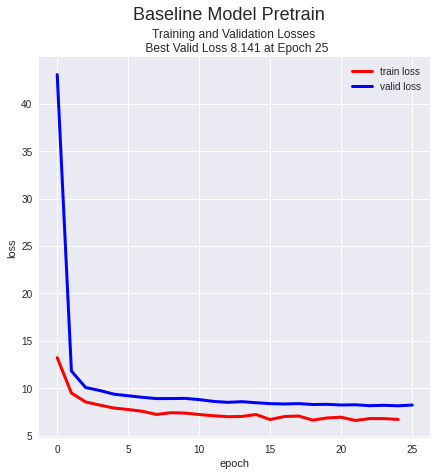

In [15]:
model = BaselineModel()
title = 'Baseline Model Pretrain'
baseline_trainer_pretrain = Trainer(model, criterion_smoothl1, trainloader, validloader, es_mode='min', description=title, patience=5, lr=1e-3, n_epochs=25)
baseline_trainer_pretrain.load_model()
plot_history(baseline_trainer_pretrain)

In [16]:
model_pretrained = baseline_trainer_pretrain.model

title = 'Baseline Model'
baseline_trainer = Trainer(model_pretrained, wrapped_criterion_smoothl1, trainloader, validloader, es_mode='min', description=title, patience=5, lr=1e-3, n_epochs=1000)
baseline_trainer.fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch    33: reducing learning rate of group 0 to 5.0000e-04.
Epoch    40: reducing learning rate of group 0 to 2.5000e-04.
Epoch    55: reducing learning rate of group 0 to 1.2500e-04.
Epoch    61: reducing learning rate of group 0 to 6.2500e-05.
Early stopping triggered!


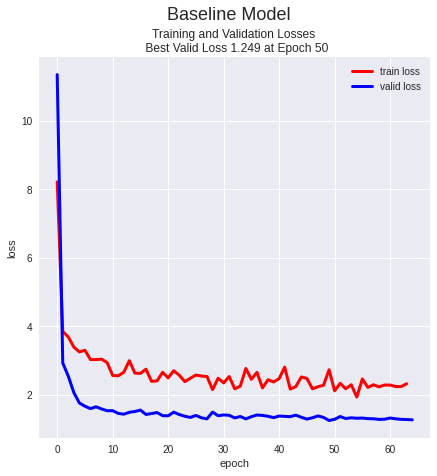

In [17]:
plot_history(baseline_trainer)

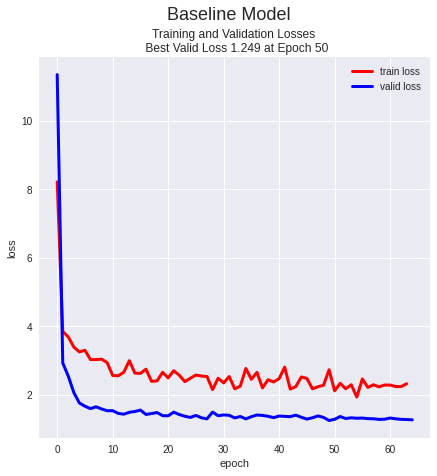

In [18]:
model = BaselineModel()
title = 'Baseline Model'
validloader = torch.utils.data.DataLoader(validset, batch_size=5, shuffle=False, num_workers=2)
baseline_trainer = Trainer(model, wrapped_criterion_smoothl1, trainloader, validloader, es_mode='min', description=title, patience=5, lr=1e-3, n_epochs=1000)
baseline_trainer.load_model()
plot_history(baseline_trainer)
(imgs_left, imgs_right), imgs_disparity, net_outs = baseline_trainer.get_sample()

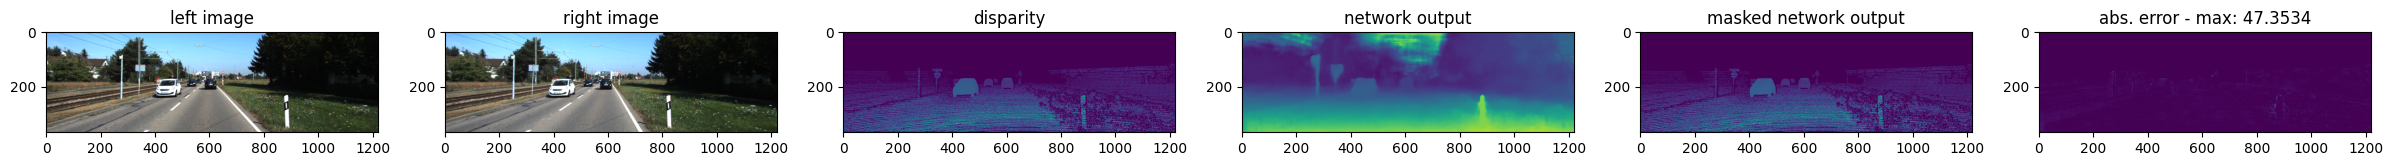

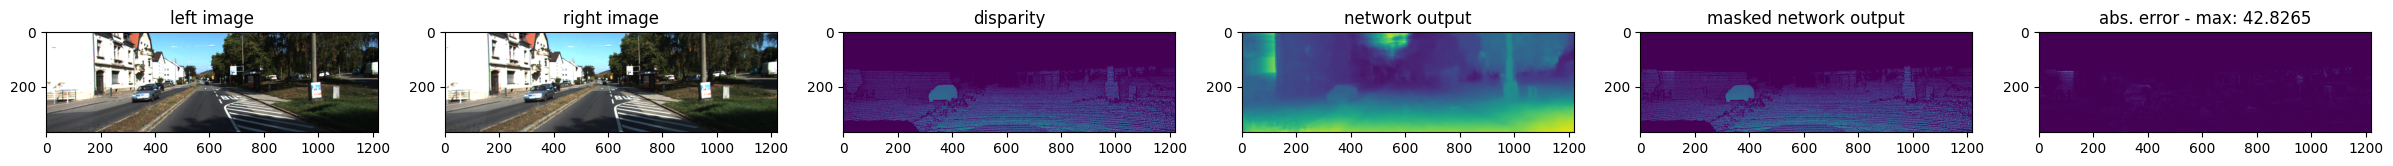

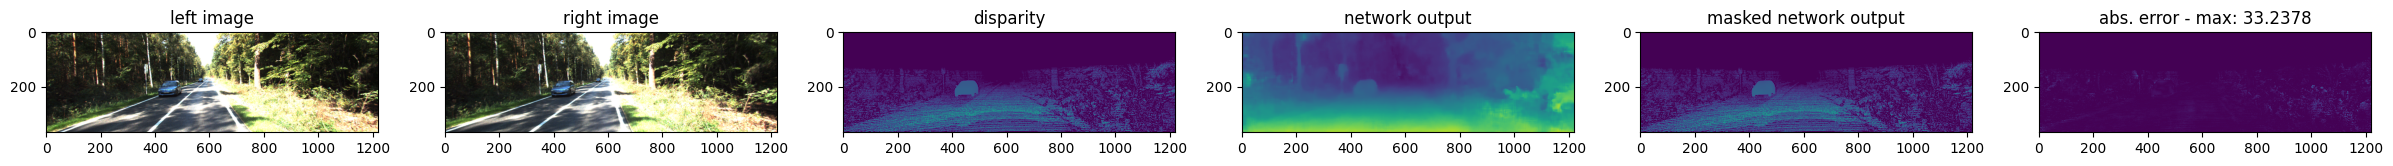

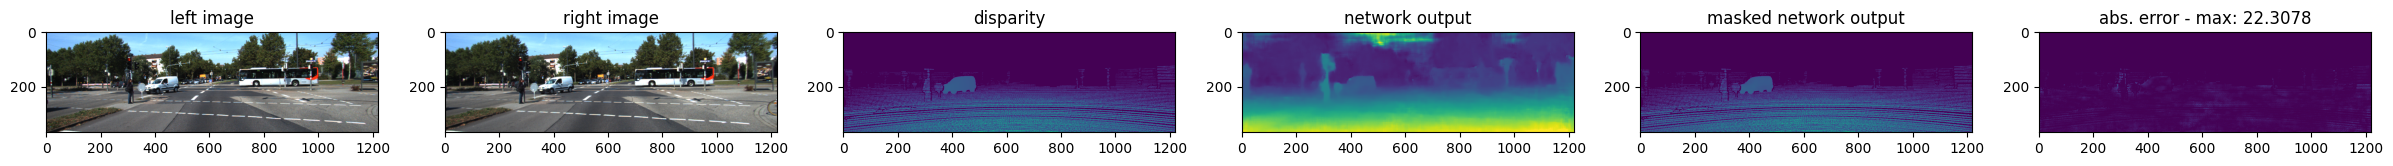

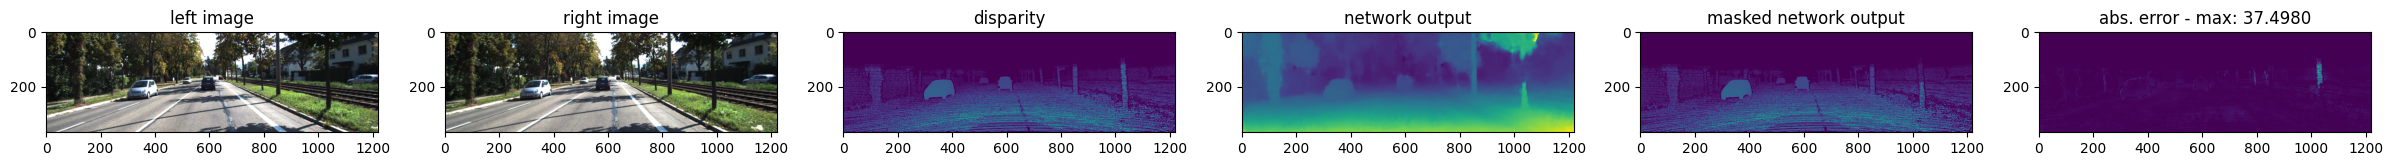

In [19]:
plt.style.use('default')
for i in range(imgs_left.shape[0]):
    img_left = imgs_left[i]
    img_right = imgs_right[i]
    img_disparity = imgs_disparity[i]
    disp_min, disp_max = img_disparity.min(), img_disparity.max()
    mask = img_disparity == 0
    net_out = net_outs[i].clone()
    
    _, axes = plt.subplots(1, 6, figsize=(30, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[2].set_title('disparity')

    axes[3].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[3].set_title('network output')

    net_out[mask] = 0
    axes[4].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[4].set_title('masked network output')
    
    err = torch.abs(img_disparity.squeeze() - net_out.squeeze())
    axes[5].imshow(err)
    axes[5].set_title(f'abs. error - max: {err.max() :.4f}')

    plt.show()